# 1. Try of solving the [Link writing process to writing quality Competition.](https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality/data)

The goal of this competition to predict the overall writting quality based on typing behaviour.

This will help explore the relationship between learners’ writing behaviors and writing performance, which could provide valuable insights for writing instruction, the development of automated writing evaluation techniques, and intelligent tutoring systems


## Constants

In [193]:
# Target will be the Score of the essay. which is rated from 0-6
NUM_RATING = 7

# train logs will be the input on which the model will base its score
TRAIN_LOG_PATH = "dataset/train_logs.csv"
TEST_LOG__PATH = "dataset/test_logs.csv"

# train scores
TRAIN_SCORES_PATH = "dataset/train_scores.csv"

# sample submissions output
SAMPLE_SUBMISSION = "dataset/sample_submission.csv"

In [194]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import keras.api._v2.keras as keras


import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

## Inspect the Data

In [195]:
sample_df = pd.read_csv(SAMPLE_SUBMISSION)
train_logs_df = pd.read_csv(TRAIN_LOG_PATH)
test_logs_df = pd.read_csv(TEST_LOG__PATH)
train_scores_df = pd.read_csv(TRAIN_SCORES_PATH)

### Inspect sample submission

In [196]:
sample_df

,id,score
0,0000aaaa,1.0
1,2222bbbb,2.0
2,4444cccc,3.0


### Inspect train_logs

In [197]:
train_logs_df

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


In [198]:
print([row for row in train_logs_df[['down_event', 'up_event']].values if row[0] != row[1]] )

[array(['q', 'm'], dtype=object), array(['q', 'i'], dtype=object), array(['q', 'o'], dtype=object), array(['q', 't'], dtype=object), array(['q', 'a'], dtype=object), array(['q', 'o'], dtype=object), array(['q', 't'], dtype=object), array(['q', 'i'], dtype=object), array(['q', 'a'], dtype=object), array(['q', 'm'], dtype=object), array(['q', 'w'], dtype=object), array(['q', 'm'], dtype=object), array(['q', 'a'], dtype=object), array(['q', 'b'], dtype=object), array(['q', 't'], dtype=object), array(['q', 'c'], dtype=object), array(['q', 'i'], dtype=object), array(['q', 'n'], dtype=object), array(['q', 'w'], dtype=object), array(['q', 'i'], dtype=object), array(['q', 't'], dtype=object), array(['q', 'w'], dtype=object), array(['q', 'i'], dtype=object), array(['q', 'e'], dtype=object), array(['q', 'w'], dtype=object), array(['q', 't'], dtype=object), array(['q', 'i'], dtype=object), array(['q', 'w'], dtype=object), array(['q', 'm'], dtype=object), array(['q', 'a'], dtype=object), array(['q

**id**               - The unique ID of the essay
**event_id**         - The index of the event, ordered chronologically
**down_time**        - The time of the down event in milliseconds
**up_time**          - The time of the up event in milliseconds
**action_time**      - The duration of the event (the difference between down_time and up_time)
**activity**         - The category of activity which the event belongs to
    - **Nonproduction**    - The event does not alter the text in any way
    - **Input**            - The event adds text to the essay
    - **Remove**           - Cut - The event removes text from the essay
    - **Paste**            - The event changes the text through a paste input
    - **Replace**          - The event replaces a section of text with another string
    - **Move**             - From [x1, y1] To [x2, y2] - The event moves a section of text spanning character index x1, y1 to a new   
                          location x2, y2
**down_event**       - The name of the event when the key/mouse is pressed
**up_event**         - The name of the event when the key/mouse is released
**text_change**      - The text that changed as a result of the event (if any)
**cursor_position**  - The character index of the text cursor after the event
**word_count**       - The word count of the essay after the event

q => is a anonymized alphabetical character

Key_down and key_up events may not necessarily occur in the same order as they are presented in the dataset. To illustrate, a writer may press down "a" and then press down "b" before he/she even releases "a". However, all the keystroke information about "a" comes before "b" in the dataframe.

### Number of Actions

Text(5.569444444444445, 0.5, 'Essays')

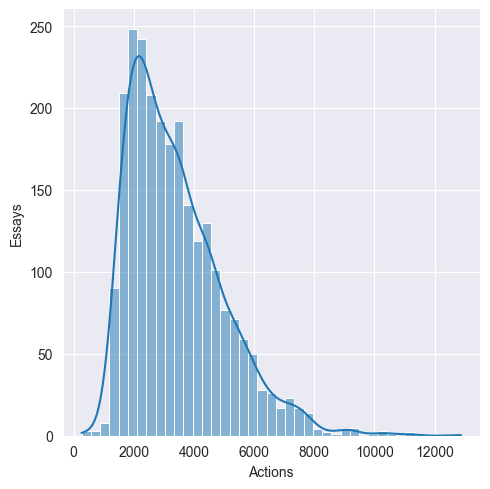

In [199]:
_ = sns.displot(train_logs_df.groupby('id')['event_id'].max(), kde=True)
plt.xlabel("Actions")
plt.ylabel("Essays")

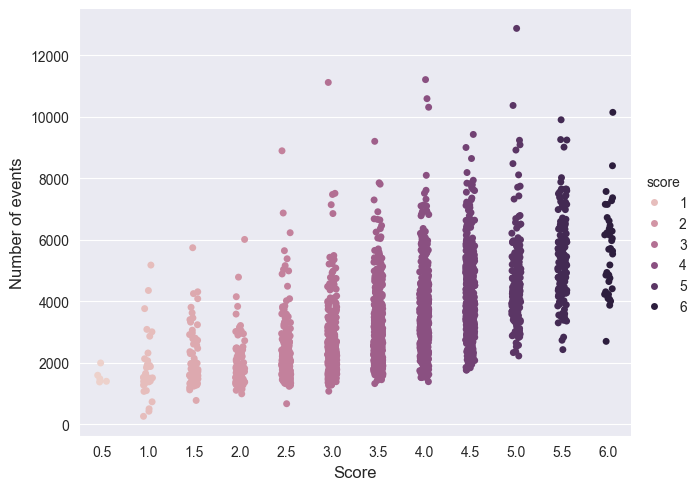

In [200]:
event_stats = train_logs_df.groupby("id")["event_id"].max().reset_index()
stats_score = event_stats.merge(train_scores_df, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="event_id" , hue="score", aspect=1.3)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of events', fontsize=12)
plt.show()

### Word Count

Text(5.569444444444445, 0.5, 'Essays')

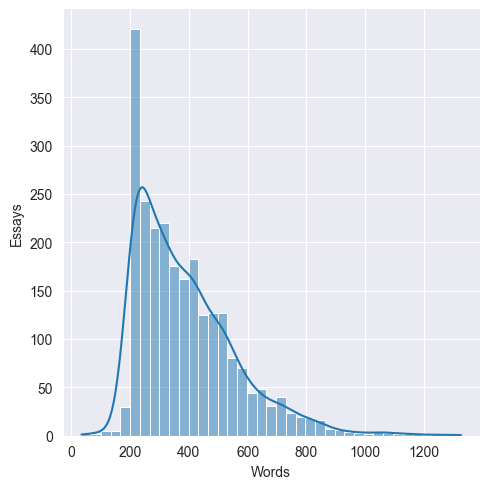

In [201]:
_ = sns.displot(train_logs_df.groupby('id')['word_count'].max(), kde=True)
plt.xlabel("Words")
plt.ylabel("Essays")

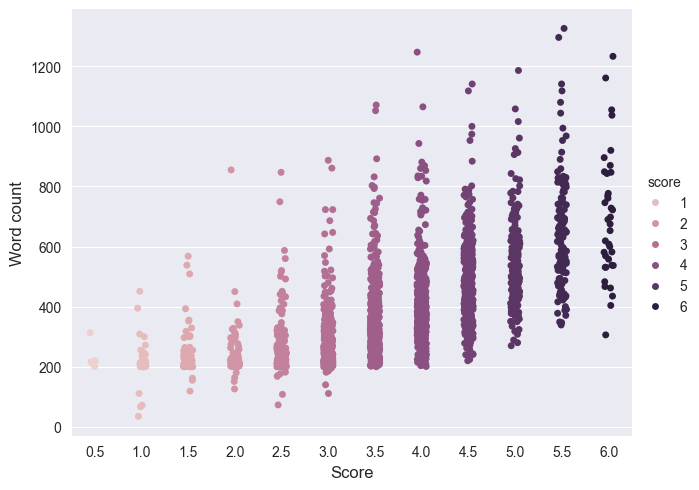

In [202]:
event_stats = train_logs_df.groupby("id")["word_count"].max().reset_index()
stats_score = event_stats.merge(train_scores_df, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="word_count", hue="score", aspect=1.3)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Word count', fontsize=12)
plt.show()

### Mean action time

Text(0, 0.5, 'Essays')

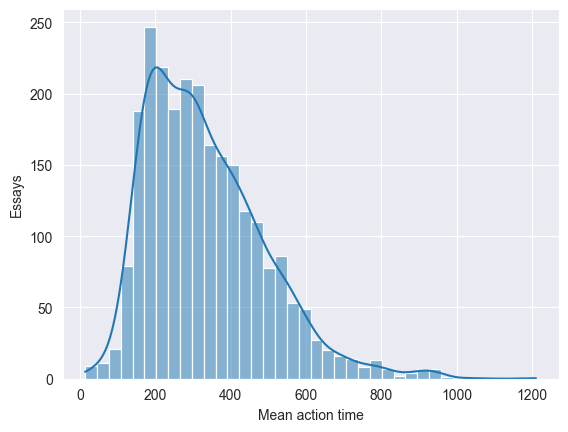

In [203]:
_ = sns.histplot(train_logs_df.groupby('id')['action_time'].sum().div(1000), kde=True)
plt.xlabel("Mean action time")
plt.ylabel("Essays")

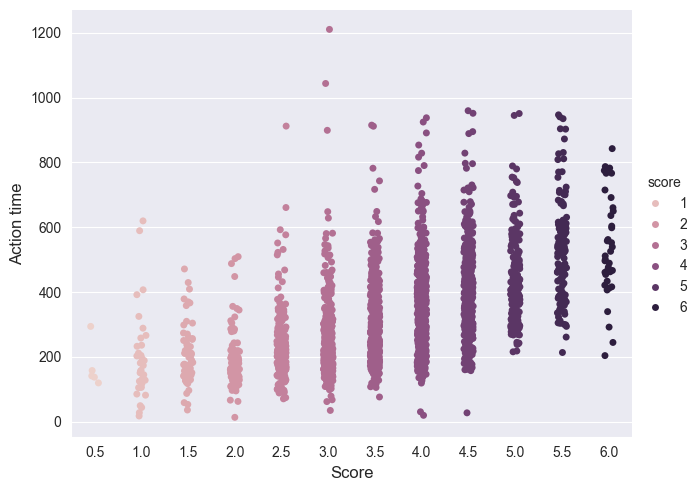

In [204]:
# activity
action_time_mean = train_logs_df.groupby('id')['action_time'].sum().div(1000).reset_index()
stats_score = action_time_mean.merge(train_scores_df, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="action_time", hue="score", aspect=1.3)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Action time', fontsize=12)
plt.show()

### Time Spent
Probably had a max time limit

Text(0.5, 0, 'Time Spent')

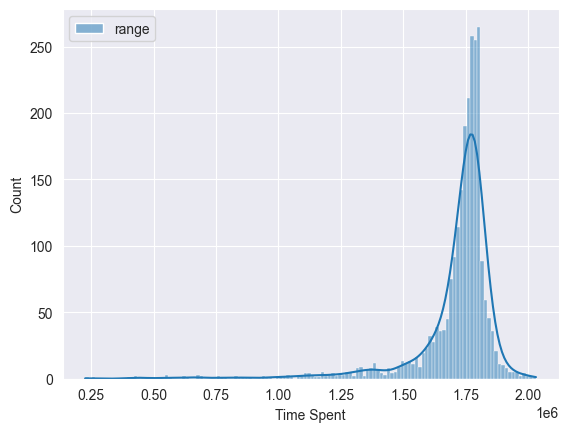

In [205]:
range_by_id = train_logs_df.groupby('id')['up_time'].apply(np.ptp).to_frame('range').reset_index()
reduced_df = range_by_id[range_by_id.range < range_by_id.range.quantile(0.98)]
sns.histplot(reduced_df, kde=True)
plt.xlabel("Time Spent")

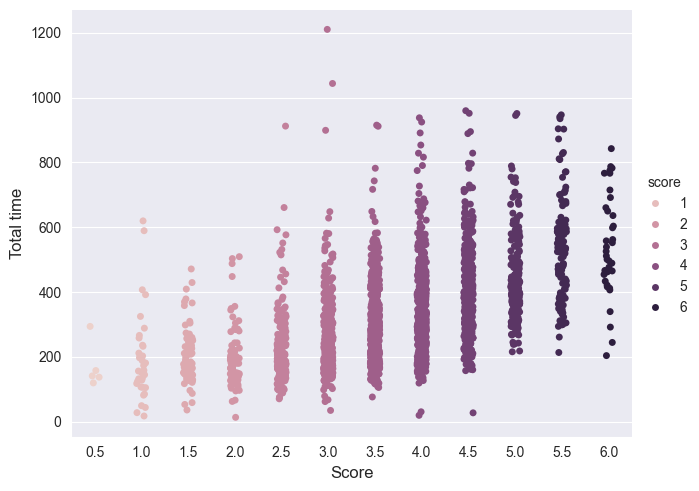

In [206]:
range_score = range_by_id.merge(train_scores_df, on="id")
catplot = sns.catplot(data=stats_score, x="score", y="action_time", hue="score", aspect=1.3)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Total time', fontsize=12)
plt.show()

### Distribution of action types

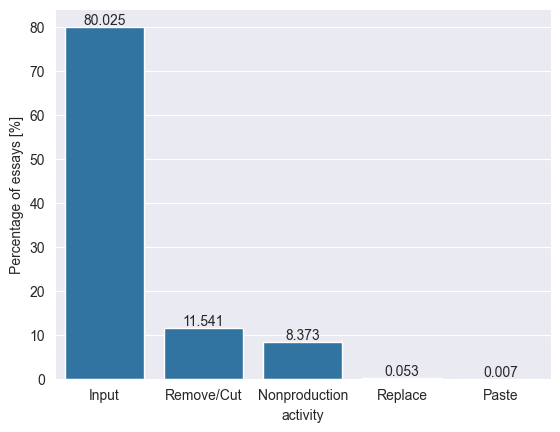

In [207]:
vals_of_interest = ['Nonproduction','Input','Remove/Cut','Paste','Replace']
sub_df = train_logs_df[train_logs_df['activity'].isin(vals_of_interest)]['activity']

tmp_stats = sub_df.value_counts()
tmp_stats = tmp_stats.div(len(sub_df)).mul(100)
tmp_stats = tmp_stats.round(3).reset_index()
tmp_stats.columns = ["activity","count"]
ax = sns.barplot(tmp_stats, x="activity", y="count", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylabel("Percentage of essays [%]")
plt.show()

In [208]:
select_activ = train_logs_df[train_logs_df['activity'].isin(vals_of_interest)][['activity', 'id']]

In [209]:
def get_dist_and_corr(activity, df, quantile=0.95):
    count_id = df.loc[df['activity'] == activity].groupby("id").count()
    
    reduced_df = count_id[count_id.activity < count_id.activity.quantile(quantile)]
    
    input_quant_score = reduced_df.merge(train_scores_df, on="id")
    sns.displot(reduced_df, kde=True, legend=False)
    plt.xlabel(f"{activity} Count", fontsize=12)
    plt.ylabel('Essays', fontsize=12)
    sns.catplot(data=input_quant_score, x="score", y="activity", hue="score", legend=False, aspect=1.3)
    plt.xlabel('Score', fontsize=12)
    plt.ylabel(f"{activity} Count", fontsize=12)
    plt.show()

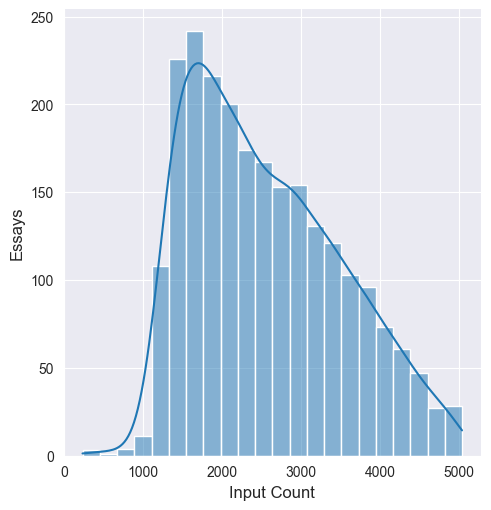

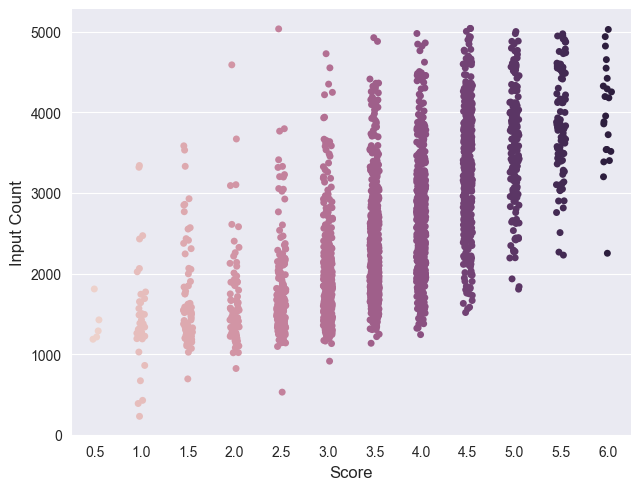

In [210]:
get_dist_and_corr("Input", select_activ)

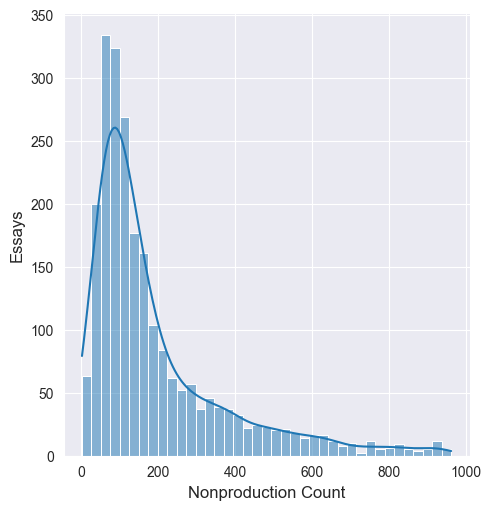

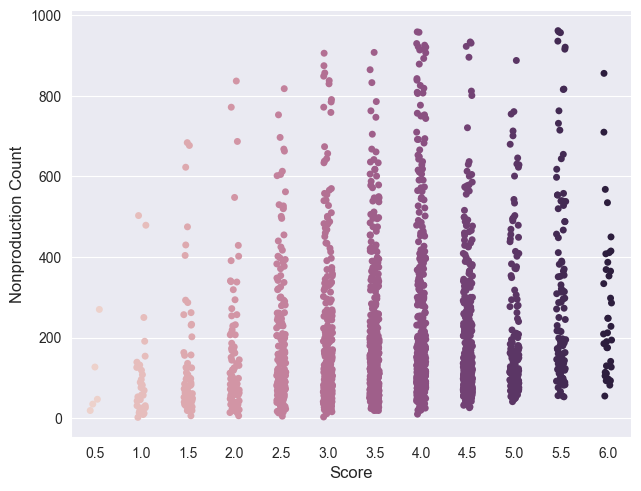

In [211]:
get_dist_and_corr("Nonproduction", select_activ)

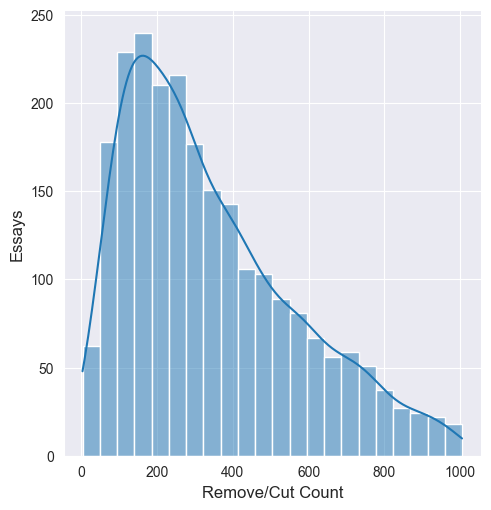

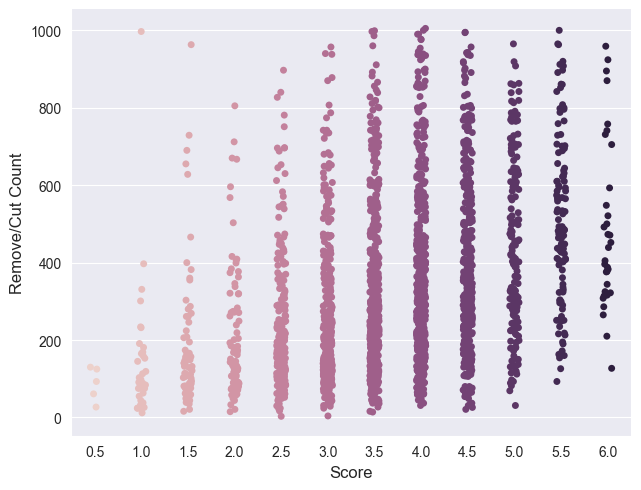

In [212]:
get_dist_and_corr("Remove/Cut", select_activ)

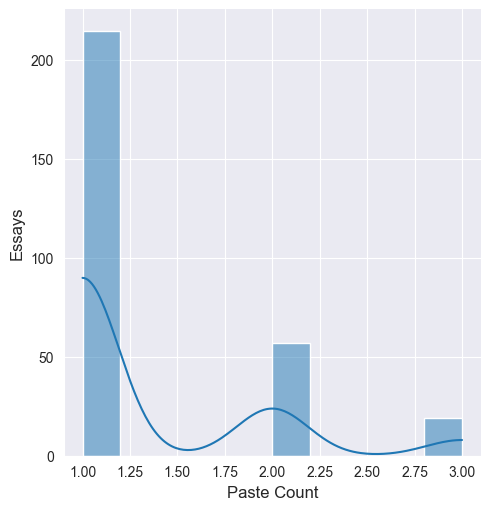

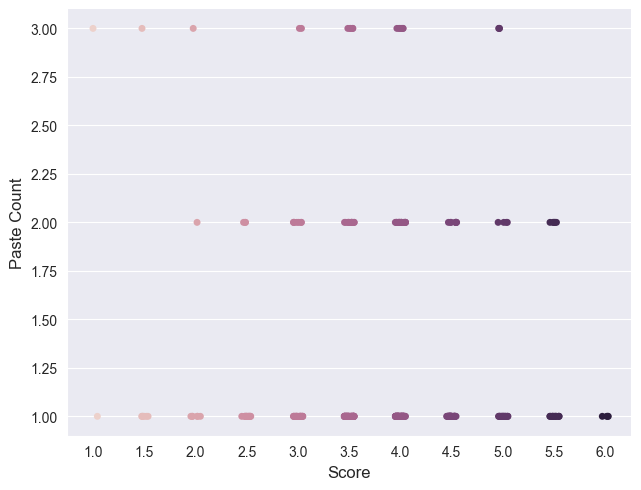

In [213]:
get_dist_and_corr("Paste", select_activ)


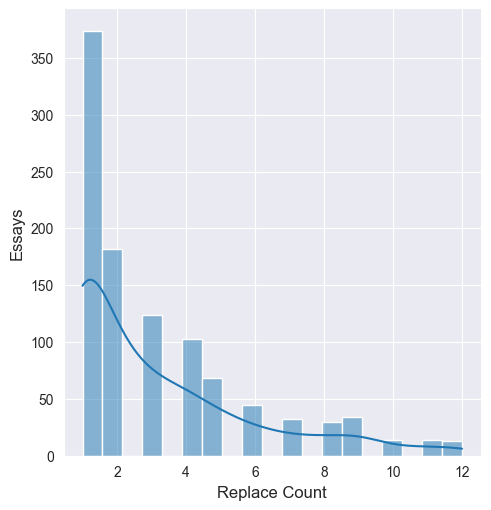

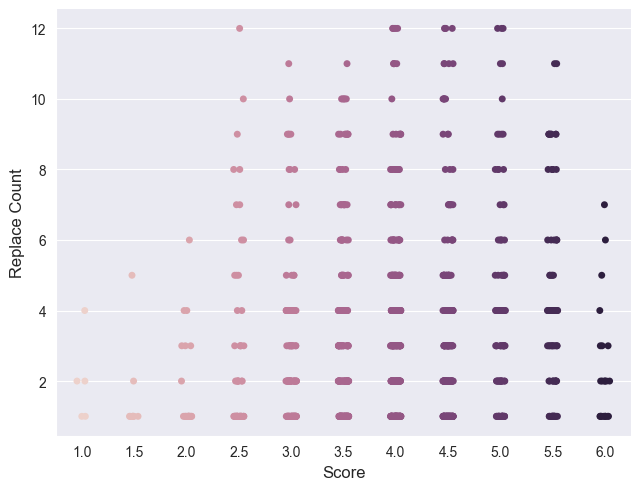

In [214]:
get_dist_and_corr("Replace", select_activ)

## Inspect train_scores

In [215]:
train_scores_df.score.max(), train_scores_df.score.min()

(6.0, 0.5)

Text(0, 0.5, 'Times achieved')

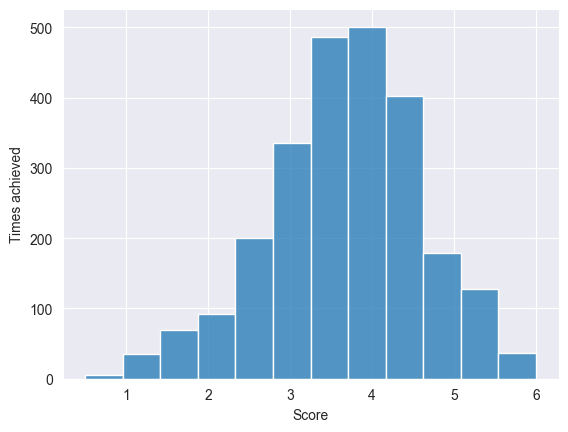

In [336]:
sns.histplot(train_scores_df.score, bins=12, )
plt.xlabel("Score")
plt.ylabel("Times achieved")

## Visualisations conclusions


To create features 
- Number of actions -> strong -> action_count
- Word count -> strong -> word_count
- Mean action time -> medium -> mean_action_time
- Total Time spend -> low -> total_time

Possible feature ideas
- Number of inputs to get ratio actions to inputs
- Number of actions categorized -> medium but maybe just because of num of actions -> maybe later
- count cursor jumps which maybe indicate correction in the end
- average word length

In [217]:
train_logs_df.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [218]:
test_logs_df

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0
5,4444cccc,2,184996,185052,56,Input,q,q,q,1,1


In [219]:
group_actions = train_logs_df.groupby('id')['event_id'].sum().to_frame('event_count')
train_df = train_scores_df.merge(group_actions, on='id')

In [220]:
time_spend = train_logs_df.groupby('id')['up_time'].apply(np.ptp).to_frame('total_time').reset_index()
train_df = train_df.merge(time_spend, on='id')


In [221]:
word_count = train_logs_df.groupby('id')['word_count'].max().to_frame('word_count')
train_df = train_df.merge(word_count, on='id')

In [222]:
mean_action_time = train_logs_df.groupby('id')['action_time'].mean().to_frame('mean_action_time')
train_df = train_df.merge(mean_action_time, on='id')

In [223]:
train_df

,id,score,event_count,total_time,word_count,mean_action_time
0,001519c8,3.5,3270403,1797412,256,116.246774
1,0022f953,3.5,3012285,1758116,323,112.221271
2,0042269b,6.0,8555316,1767129,404,101.837766
3,0059420b,2.0,1211346,1362956,206,121.848329
4,0075873a,4.0,3204246,1583779,252,123.943896
...,...,...,...,...,...,...
2466,ffb8c745,3.5,11231430,1769098,461,105.437856
2467,ffbef7e5,4.0,3391710,1777147,438,82.266129
2468,ffccd6fd,1.5,4692516,1935793,201,75.605615
2469,ffec5b38,5.0,5256903,1488416,413,89.277915


In [224]:
train_df = train_df.drop('id', axis=1)

In [225]:
train_df = train_df.astype('float32')

In [226]:
train_df[:10]

,score,event_count,total_time,word_count,mean_action_time
0,3.5,3270403.0,1797412.0,256.0,116.246773
1,3.5,3012285.0,1758116.0,323.0,112.221268
2,6.0,8555316.0,1767129.0,404.0,101.837769
3,2.0,1211346.0,1362956.0,206.0,121.848328
4,4.0,3204246.0,1583779.0,252.0,123.943893
5,2.0,2445366.0,1736172.0,275.0,81.404343
6,4.5,1558495.0,1761387.0,242.0,109.717850
7,4.0,2769481.0,1692653.0,308.0,90.755630
8,3.5,1256905.0,1792101.0,223.0,75.011360
9,4.5,30627052.0,1842896.0,739.0,93.343216


In [227]:
train_df = train_df[:(int(len(train_df) * 0.8))]
test_df = train_df[(int(len(train_df) * 0.8)):]

In [228]:
train_features = train_df.to_numpy()[:, 1:]
test_features = test_df.to_numpy()[:, 1:]

In [265]:
robust_scaler = RobustScaler(unit_variance=True)

robust_scaler_train_data = robust_scaler.fit_transform(train_features)
robust_scaler_test_data = robust_scaler.fit_transform(test_features)

In [275]:
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_features)
scaled_test_data = scaler.transform(test_features)

In [276]:
robust_scaler_test_data

array([[  1.6829267 ,  -0.7596922 ,   0.1882297 ,   0.44396612],
       [ -0.7172918 , -21.486492  ,  -0.8841092 ,  -1.0114022 ],
       [ -0.67285293,   0.43088678,  -0.91833276,   0.63458437],
       ...,
       [ -0.4080684 ,  -3.5351644 ,  -0.1711179 ,  -0.25749844],
       [  0.02260293,  -1.4719263 ,   0.32512403,   1.6657141 ],
       [ -0.620479  ,  -1.7799195 ,  -0.9126288 ,  -0.5315562 ]],
      dtype=float32)

In [277]:
px.histogram(scaled_train_data)

In [300]:
train_df.score.to_numpy()

array([3.5, 3.5, 6. , ..., 4. , 4. , 2. ], dtype=float32)

In [233]:
len(train_df.score.unique())

12

In [317]:
train_data_labels, scaled_train_data_features = train_df.score, scaled_train_data
test_data_labels, scaled_test_data_features = train_df.score, scaled_test_data

#train_data_labels, scaled_train_data_features = tf.one_hot(train_df.score, len(train_df.score.unique())), scaled_train_data
#test_data_labels, scaled_test_data_features = tf.one_hot(test_df.score, len(train_df.score.unique())), scaled_test_data

In [318]:
test_data_labels, scaled_test_data_features

(0       3.5
 1       3.5
 2       6.0
 3       2.0
 4       4.0
        ... 
 1971    4.5
 1972    4.0
 1973    4.0
 1974    4.0
 1975    2.0
 Name: score, Length: 1976, dtype: float32,
 array([[0.22537306, 0.31582505, 0.2796282 , 0.3566049 ],
        [0.01335248, 0.0693742 , 0.13400464, 0.24702615],
        [0.01727793, 0.32998154, 0.12935708, 0.37095708],
        ...,
        [0.04066737, 0.28282344, 0.2308288 , 0.30378968],
        [0.07871024, 0.30735627, 0.29821843, 0.4485937 ],
        [0.02190432, 0.30369407, 0.13013168, 0.2831551 ]], dtype=float32))

In [319]:
train_ds_features = tf.data.Dataset.from_tensor_slices(scaled_train_data_features)
train_ds_labels = tf.data.Dataset.from_tensor_slices(train_data_labels)

train_ds = tf.data.Dataset.zip(train_ds_features, train_ds_labels)

test_ds_features = tf.data.Dataset.from_tensor_slices(scaled_test_data_features)
test_ds_labels = tf.data.Dataset.from_tensor_slices(test_data_labels)

test_ds = tf.data.Dataset.zip(test_ds_features, test_ds_labels)

In [320]:
list(test_ds.as_numpy_iterator())

[(array([0.22537306, 0.31582505, 0.2796282 , 0.3566049 ], dtype=float32), 3.5),
 (array([0.01335248, 0.0693742 , 0.13400464, 0.24702615], dtype=float32), 3.5),
 (array([0.01727793, 0.32998154, 0.12935708, 0.37095708], dtype=float32), 6.0),
 (array([0.11141825, 0.32897395, 0.28814873, 0.2447572 ], dtype=float32), 2.0),
 (array([0.1407022 , 0.35271832, 0.23547636, 0.2991546 ], dtype=float32), 4.0),
 (array([0.0553714 , 0.31594118, 0.27033308, 0.2521249 ], dtype=float32), 2.0),
 (array([0.06317949, 0.32736287, 0.2904725 , 0.39865676], dtype=float32), 4.5),
 (array([0.24203853, 0.32251573, 0.53292024, 0.2803896 ], dtype=float32), 4.0),
 (array([0.25757167, 0.36288643, 0.6289698 , 0.26816162], dtype=float32), 3.5),
 (array([0.02166433, 0.32249883, 0.14252517, 0.4943091 ], dtype=float32), 4.5),
 (array([0.37683398, 0.2849567 , 0.31990707, 0.35135522], dtype=float32), 4.5),
 (array([0.12709755, 0.31843802, 0.31758326, 0.29032487], dtype=float32), 2.5),
 (array([0.02763009, 0.04630591, 0.19442

In [321]:
len(train_ds), len(test_ds)

(1976, 396)

In [322]:
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [323]:
train_ds, len(train_ds)

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 62)

In [332]:
input = keras.layers.Input(shape=[4], dtype=tf.float32)

x = keras.layers.Dense(8, activation="relu")(input)
x = keras.layers.Dense(16, activation="relu")(x)
x = keras.layers.Dense(32, activation="relu")(x)
output = keras.layers.Dense(1, activation="sigmoid")(x)

baseline_model = keras.Model(inputs= input, outputs= output)

baseline_model.compile(loss="mae",
                       optimizer='adam',
                       metrics=keras.metrics.RootMeanSquaredError())

baseline_model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_80 (Dense)            (None, 8)                 40        
                                                                 
 dense_81 (Dense)            (None, 16)                144       
                                                                 
 dense_82 (Dense)            (None, 32)                544       
                                                                 
 dense_83 (Dense)            (None, 1)                 33        
                                                                 
Total params: 761 (2.97 KB)
Trainable params: 761 (2.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [333]:
baseline_history = baseline_model.fit(train_ds, steps_per_epoch=len(train_ds),
                   validation_data=test_ds, validation_steps=len(test_ds),
                   epochs=100)

Epoch 1/100
62/62 [==============================] - 0s 2ms/step - loss: 3.1476 - root_mean_squared_error: 3.3100 - val_loss: 3.0026 - val_root_mean_squared_error: 3.1730
Epoch 2/100
62/62 [==============================] - 0s 672us/step - loss: 2.8554 - root_mean_squared_error: 3.0318 - val_loss: 2.7458 - val_root_mean_squared_error: 2.9299
Epoch 3/100
62/62 [==============================] - 0s 691us/step - loss: 2.7395 - root_mean_squared_error: 2.9220 - val_loss: 2.7205 - val_root_mean_squared_error: 2.9060
Epoch 4/100
62/62 [==============================] - 0s 646us/step - loss: 2.7289 - root_mean_squared_error: 2.9125 - val_loss: 2.7176 - val_root_mean_squared_error: 2.9033
Epoch 5/100
62/62 [==============================] - 0s 675us/step - loss: 2.7277 - root_mean_squared_error: 2.9116 - val_loss: 2.7173 - val_root_mean_squared_error: 2.9030
Epoch 6/100
62/62 [==============================] - 0s 650us/step - loss: 2.7276 - root_mean_squared_error: 2.9114 - val_loss: 2.7172 - 

In [294]:
px.line(baseline_history.history)

Well this is not working. The metadata alone is not event close to be enough to give accurat predictions on the data.
Second experiment is going to be with a LSTM sequentialy looking at the data.

RMSE => 2.9